# Import Library 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

# Import Data

In [2]:
df = pd.read_csv('data/credit-downsampled.csv')
df.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents,Class
0,1.000000,54,0,0.000000,1666.0,1,0,0,0,0.0,0
1,0.497080,40,0,0.510355,4200.0,8,0,2,0,3.0,0
2,0.797681,40,1,0.047542,3070.0,6,0,0,0,2.0,0
3,0.043304,61,0,244.000000,NaN,14,0,0,0,0.0,0
4,0.810945,49,0,4.000000,NaN,1,0,0,0,0.0,0


In [3]:
df.shape

(20052, 11)

Data terdiri dari 20052 baris dan 11 kolom.

In [4]:
df.dtypes

RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30.59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60.89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
Class                                     int64
dtype: object

Tipe data telah sesuai.

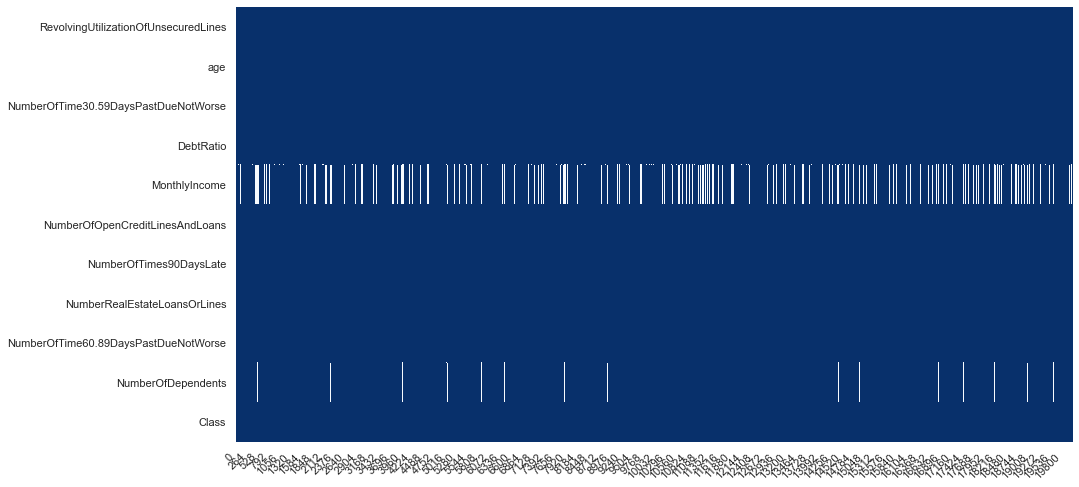

In [5]:
plot_missing_value(df)

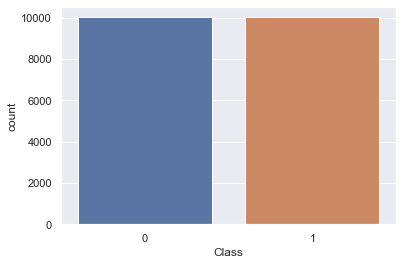

In [6]:
sns.countplot(df.Class);

Target variabel balanced.

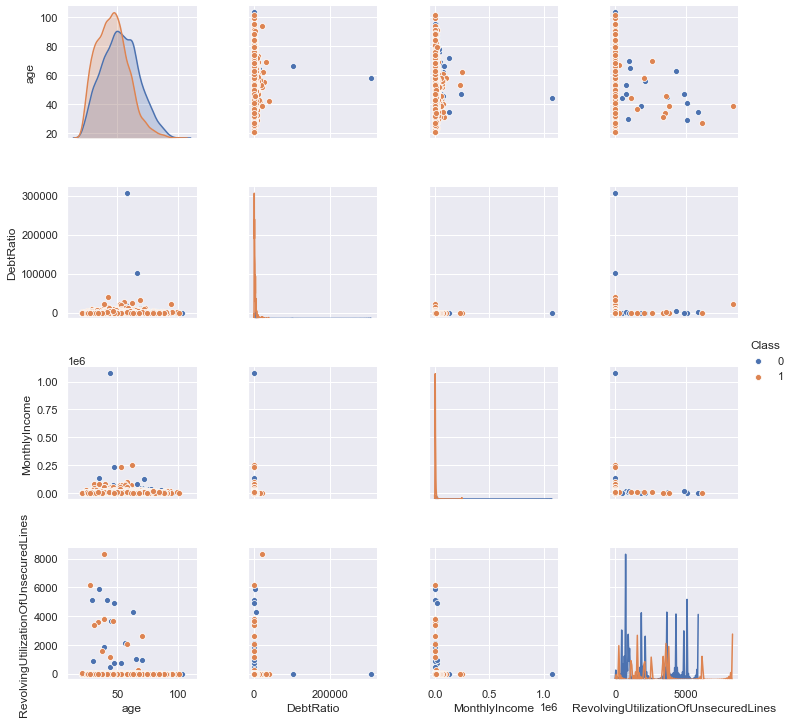

In [7]:
sns.pairplot(df, hue='Class', vars=['age','DebtRatio','MonthlyIncome','RevolvingUtilizationOfUnsecuredLines']);

# Dataset Splitting

In [8]:
X = df.drop(columns="Class")
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16041, 10), (4011, 10), (16041,), (4011,))

# Modeling 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Integer, Real
from jcopml.tuning import grid_search_params as gsp

In [10]:
gsp.logreg_params

{'algo__fit_intercept': [True, False],
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [11]:
X_train.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents
7454,0.035606,81,0,0.017261,7125.0,7,0,0,0,0.0
4502,0.906419,25,0,0.092293,4333.0,3,0,0,0,0.0
4094,1.000000,51,0,5364.000000,NaN,8,0,1,0,NaN
15055,1.385382,22,1,12.000000,NaN,1,0,0,0,NaN
6039,0.004672,61,0,0.000605,4960.0,12,0,0,0,1.0


In [12]:
list(X_train.columns)

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30.59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60.89DaysPastDueNotWorse',
 'NumberOfDependents']

In [13]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), list(X_train.columns)),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-2, random_state=42))
])


model = RandomizedSearchCV(pipeline, gsp.logreg_params, cv=10, n_iter=8, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:   12.3s finished


{'algo__fit_intercept': False, 'algo__C': 100.0}
0.7253911850882114 0.7257027213896723 0.7192720019945151


# Features Important 

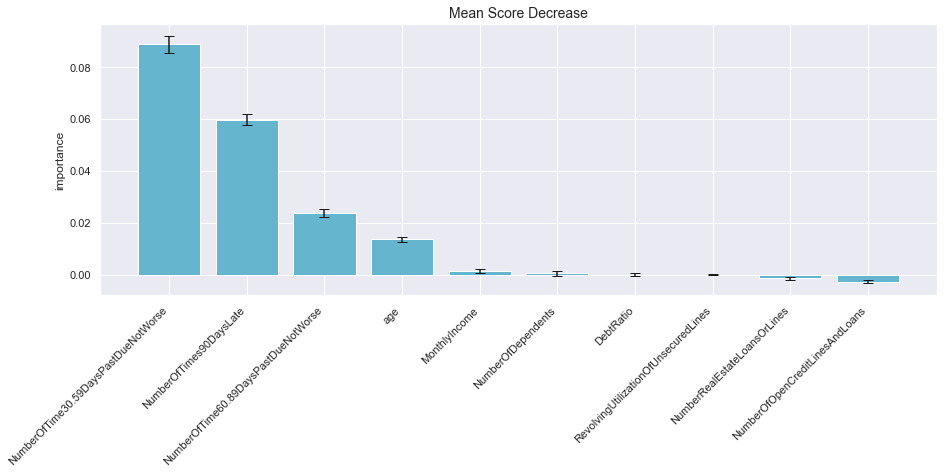

In [14]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

In [15]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['age','NumberOfTime30.59DaysPastDueNotWorse','MonthlyIncome','NumberOfOpenCreditLinesAndLoans',
                             'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines','NumberOfTime60.89DaysPastDueNotWorse']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-2, random_state=42))
])


model = RandomizedSearchCV(pipeline, gsp.logreg_params, cv=10, n_iter=8, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    4.0s


{'algo__fit_intercept': True, 'algo__C': 1000.0}
0.7250171435696029 0.7253917387217315 0.7237596609324358


[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:    7.2s finished


# Polynomial Features

In [16]:
gsp.logreg_poly_params

{'prep__numeric__poly__degree': [1, 2, 3],
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__fit_intercept': [True, False],
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [17]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['age','NumberOfTime30.59DaysPastDueNotWorse','MonthlyIncome','NumberOfOpenCreditLinesAndLoans',
                             'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines','NumberOfTime60.89DaysPastDueNotWorse']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-2, random_state=42))
])


model = RandomizedSearchCV(pipeline, gsp.logreg_poly_params, cv=10, n_iter=8, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:   12.8s finished


{'prep__numeric__poly__interaction_only': True, 'prep__numeric__poly__degree': 3, 'algo__fit_intercept': False, 'algo__C': 100.0}
0.7389813602643227 0.7394796497851944 0.7379705809025181


# Fine Tuning 

In [18]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['age','NumberOfTime30.59DaysPastDueNotWorse','MonthlyIncome','NumberOfOpenCreditLinesAndLoans',
                             'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines','NumberOfTime60.89DaysPastDueNotWorse']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-2, random_state=42))
])


parameter = {'prep__numeric__poly__degree': [1, 2, 3],
             'prep__numeric__poly__interaction_only': [True, False],
             'algo__fit_intercept': [True, False],
             'algo__C': [100]}


model = RandomizedSearchCV(pipeline, parameter, cv=10, n_iter=8, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:   10.5s finished


{'prep__numeric__poly__interaction_only': True, 'prep__numeric__poly__degree': 3, 'algo__fit_intercept': False, 'algo__C': 100}
0.7389813602643227 0.7394796497851944 0.7379705809025181


Setelah dilakukan fine tuning kita telah mendapatkan hyperparameter yang optimal.

# Evaluasi 

In [19]:
from jcopml.plot import plot_classification_report, plot_confusion_matrix, plot_roc_curve

In [20]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.69      0.88      0.77      8020
           1       0.83      0.60      0.70      8021

    accuracy                           0.74     16041
   macro avg       0.76      0.74      0.73     16041
weighted avg       0.76      0.74      0.73     16041


Test report
              precision    recall  f1-score   support

           0       0.69      0.88      0.77      2006
           1       0.83      0.59      0.69      2005

    accuracy                           0.74      4011
   macro avg       0.76      0.74      0.73      4011
weighted avg       0.76      0.74      0.73      4011



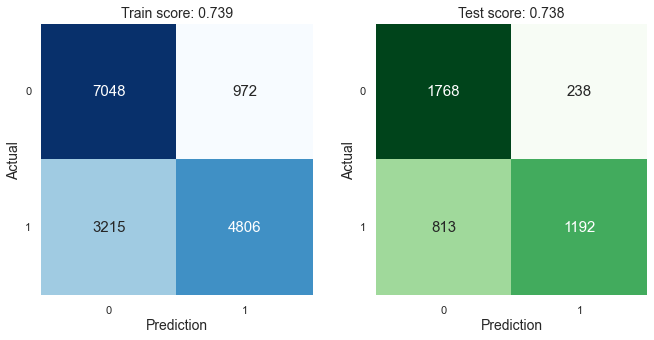

In [21]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

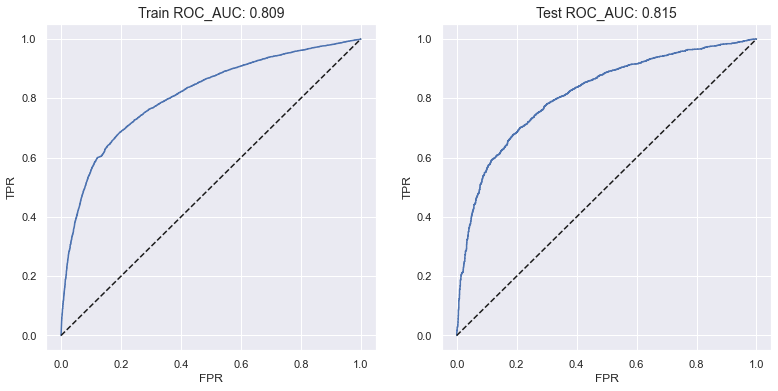

In [22]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)